# Information Retrieval

For this type of system we will carry out a joint experimentation. Where we will experiment with:
- Text splitting
- Vectorisation method

To measure the quality of the system, we will use the defined metric TPPI.

## 0. Set up

In [1]:
# Switch to home project directory
%cd ../..

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/alejandro.medrano/Projects/UNITE_TALKING_POINTS


In [2]:
import json
import os

import pandas as pd
import numpy as np

import spacy

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr, kendalltau

from bert_score import BERTScorer
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import logging
logging.set_verbosity_error()

from tqdm.notebook import tqdm

from textstat import flesch_reading_ease

from src.unite_talking_points.utils.config.config_loader import ConfigLoader
from typing import TypedDict
import openai

In [3]:
config = ConfigLoader().load_config(current_directory_is_root=True)

In [4]:
os.environ["OPENAI_API_KEY"] = config['External-services']['openai_api_key']
client = openai.OpenAI(api_key=config['External-services']['openai_api_key'])

In [5]:
class TPPIResult(TypedDict):
    TPPI: float
    BertScore: float
    Normalized_BertScore: float
    Perplexity: float
    Normalized_Perplexity: float
    Flesch: float
    Normalized_Flesch: float


class TPPI:
    def __init__(self, model_type: str = 'bert-base-uncased'):
        """
        Inicializa el normalizador de puntuaciones y los modelos necesarios para los cálculos.
        """
        self.scorer = BERTScorer(model_type=model_type)
        self.gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    @staticmethod
    def normalize_bert_score(bert_score: float) -> float:
        """
        Normaliza el puntaje BERT en un rango de 0 a 1.
        """
        return (bert_score + 1) / 2

    @staticmethod
    def normalize_perplexity(perplexity: float) -> float:
        """
        Normaliza el valor de la perplejidad en un rango de 0 a 1.
        """
        # Aseguramos que la perplexidad mínima sea al menos 1 para evitar división por cero
        perplexity = max(perplexity, 1)
        # Invertimos la fórmula para que valores bajos de perplexidad den valores altos normalizados
        return 1 - (min(perplexity, 100) - 1) / 99

    @staticmethod
    def normalize_flesch(flesch: float) -> float:
        """
        Normaliza el puntaje de Flesch en un rango de 0 a 1.
        """
        return max(min(flesch, 100), 0) / 100

    def calculate_bert_score(self, reference_text: str, generated_text: str) -> float:
        """
        Calcula el BertScore entre un texto de referencia y uno generado.
        """
        P, R, F1 = self.scorer.score([reference_text], [generated_text], verbose=False)
        bert_score = F1.item()
        return bert_score

    def calculate_perplexity(self, text: str) -> float:
        """
        Calcula la perplejidad de un texto utilizando el modelo GPT-2.
        """
        encode = self.gpt2_tokenizer.encode(text, return_tensors='pt')
        with torch.no_grad():
            loss = self.gpt2_model(encode, labels=encode)[0]
        perplexity = torch.exp(loss).item()
        return perplexity

    @staticmethod
    def calculate_flesch(text: str) -> float:
        """
        Calcula el puntaje de Flesch Reading Ease de un texto.
        """
        flesch_score = flesch_reading_ease(text)
        return flesch_score

    def calculate_tppi(self, original_text: str, generated_text: str) -> TPPIResult:
        """
        Calcula el TPPI basado en los textos de referencia y generados, devolviendo los puntajes de BERT,
        perplejidad y Flesch tanto normalizados como sin normalizar.
        """
        # Calcula BertScore
        bert_score = self.calculate_bert_score(original_text, generated_text)
        normalized_bert_score = self.normalize_bert_score(bert_score)

        # Calcula Perplejidad
        perplexity = self.calculate_perplexity(generated_text)
        normalized_perplexity = self.normalize_perplexity(perplexity)

        # Calcula Flesch
        flesch = self.calculate_flesch(generated_text)
        normalized_flesch = self.normalize_flesch(flesch)

        # Calcula TPPI
        tppi_score = 0.5 * normalized_bert_score + 0.25 * normalized_perplexity + 0.25 * normalized_flesch

        # Devuelve todos los valores en un TypedDict
        return TPPIResult(
            TPPI=tppi_score,
            BertScore=bert_score,
            Normalized_BertScore=normalized_bert_score,
            Perplexity=perplexity,
            Normalized_Perplexity=normalized_perplexity,
            Flesch=flesch,
            Normalized_Flesch=normalized_flesch
        )


## 1. Data loading

In [6]:
def load_json_data(data_dir):
    """
    Load JSON data from the specified directory into a pandas DataFrame.

    Args:
    - data_dir (str): Path to the directory containing JSON files.

    Returns:
    - df (pd.DataFrame): DataFrame containing the loaded JSON data.
    """
    # Initialize empty lists to store data
    file_names = []
    labels = []
    document_names = []
    meeting_names = []
    meeting_dates = []
    contents = []
    prompts = []

    # Iterate over each JSON file in the directory
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            with open(os.path.join(data_dir, filename), 'r') as file:
                data = json.load(file)
                # Extract data from each JSON file and append to lists
                file_names.append(filename)
                labels.append(data['label'])
                document_names.append(data['document_name'])
                meeting_names.append(data['meeting_name'])
                meeting_dates.append(data['meeting_date'])
                contents.append(data['content'])
                prompts.append(data['prompt'])

    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'file_name': file_names,
        'label': labels,
        'document_name': document_names,
        'meeting_name': meeting_names,
        'meeting_date': meeting_dates,
        'content': contents,
        'prompt': prompts
    })

    return df

In [7]:
df = load_json_data(config['Directories']['raw_data_path'])

In [8]:
df

,file_name,label,document_name,meeting_name,meeting_date,content,prompt
0,PSGD 2023-03-06 Talking Points for USG DOS on ...,ai,Talking Points for USG DOS on Generative AI,Senior Manamement Group,09-03-2023,Generative Artificial Intelligence is a form o...,Generate talking points addressing the recent ...
1,BN DOS USG on Implementation of Digital Transf...,peacekeeping,Briefing Note for USG DOS,Implementation of the Peacekeeping Digital Tra...,01-06-2022,DOS is a partner in the digital transformation...,Create talking points highlighting the partner...
2,2022-12-08 DRAFT Remarks for 7th Pannel ICT Af...,digital_transformation,Remarks for ASG OICT,7th Panel: Information and Communications Tech...,08-12-2022,Acknowledgment of the crucial moment for ICT i...,Create a draft for a keynote address by a UN o...
3,2022-10-14 764 CXOTalk ASG OICT FINAL digital ...,digital_transformation,CITO Interview CXOTalk Show,"CXOTALK EPISODE #764, DIGITAL TECHNOLOGIES & ...",14-10-2022,Role of Technology at the UN: Technology plays...,Generate talking points on how technology inte...
4,2022-08-24 TECH ENVOY TPs - CITO cybersecurity...,cybersecurity,Talking Points for ASG OICT,Meeting with the incoming Special Envoy for Te...,24-09-2022,"Trust in the integrity, reliability and securi...",Generate talking points about the importance o...
5,2022-08-24 TECH ENVOY TPs - CITO ai.json,ai,Talking Points for ASG OICT,Meeting with the incoming Special Envoy for Te...,24-08-2022,Welcome!\nI would very much like to see contin...,Please draft a message welcoming collaboration...
6,2022-03-02 Talking Points for USG DMSPC Our Co...,data_strategy,Talking Points for USG DMSPC - Our Common Agenda,,02-03-2022,OICT continues to support business entities in...,Generate talking points on the ongoing efforts...
7,2023-09-15 Opening Remarks UNGS ScienceSummit ...,data_strategy,Opening Remarks for ASG OICT,UNGA Science Summit,12-09-2023,Emphasis on the importance of science as a cen...,Generate a set of strategic talking points for...
8,SG remarks to the Security Council on Artifici...,ai,SG remarks to the Security Council on Artifici...,SG remarks to the Security Council on Artifici...,01-09-2023,"AI has reached unprecedented speed and reach, ...",Generate a comprehensive overview of the curre...
9,2022-10-14 764 CXOTalk ASG OICT FINAL ict stra...,ict_strategy,CITO Interview CXOTalk Show,"CXOTALK EPISODE #764, DIGITAL TECHNOLOGIES & T...",14-10-2022,Role and Functions of the ICT Office: The Chie...,Generate a detailed overview of the Informatio...


## 2. Data preprocessing

In [9]:
# Load the English language model
nlp = spacy.load('en_core_web_trf')

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_trf' (3.7.3) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

In [10]:
# Function to preprocess text
def preprocess_text(text):
    # Parse the text with spaCy
    doc = nlp(text)
    
    # Tokenization, removing stop words, punctuation, and lemmatization
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [11]:
# Apply the preprocessing function to the 'content' column
df['preprocessed_content'] = df['content'].apply(preprocess_text)
df['preprocessed_prompt'] = df['prompt'].apply(preprocess_text)

# Display the preprocessed content
print("Preprocessed Content:")
print(df['preprocessed_content'].head())

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):
/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


Preprocessed Content:
0    generative artificial intelligence form ai cre...
1    dos partner digital transformation peacekeepin...
2    acknowledgment crucial moment ict transform wo...
3    role technology un technology play central rol...
4    trust integrity reliability security digital t...
Name: preprocessed_content, dtype: object


In [12]:
df['meeting_date'] = pd.to_datetime(df['meeting_date'], format='%d-%m-%Y')

## 3. Experimentation

### 3.1 Vectorization experimentation

In [13]:
def get_openai_embedding(text, model="text-embedding-3-large"):
    response = client.embeddings.create(
        model=model,
        input=[text],
        encoding_format="float"
    )
    # Extract the embedding vector
    embedding = np.array(response.data[0].embedding).reshape(1, -1)
    return embedding

In [14]:
# Vectorización con TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_content'])
tfidf_prompt_matrix = tfidf_vectorizer.transform(df['preprocessed_prompt'])

# Vectorización con OpenAI
embedding_matrix = np.vstack(df['content'].apply(lambda x: get_openai_embedding(x)))
embedding_prompt_matrix = np.vstack(df['prompt'].apply(lambda x: get_openai_embedding(x)))

In [15]:
# Initialize TPPI scoring system
tppi = TPPI()

# Function to conduct experiments
def conduct_experiment(df, vector_matrix, prompt_matrix, method):
    results = []
    for i in tqdm(range(len(df))):
        # Find the most relevant document
        cosine_similarities = cosine_similarity(prompt_matrix[i].reshape(1, -1), vector_matrix).flatten()
        cosine_similarities[i] = -1  # exclude the document itself
        most_relevant_doc_index = cosine_similarities.argmax()
        most_relevant_doc = df.iloc[most_relevant_doc_index]

        # Calculate TPPI
        tppi_result = tppi.calculate_tppi(df['content'][i], most_relevant_doc['content'])
        tppi_result['file_name'] = df['file_name'][i]
        tppi_result['method'] = method
        results.append(tppi_result)

    return results

# Run experiments
tfidf_results = conduct_experiment(df, tfidf_matrix, tfidf_prompt_matrix, "TF-IDF")
embedding_results = conduct_experiment(df, embedding_matrix, embedding_prompt_matrix, "Embedding")

# Combine and save results
all_results = pd.DataFrame(tfidf_results + embedding_results)

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
# Calcula estadísticas básicas para cada método
statistics = all_results.groupby('method').agg({
    'TPPI': ['mean', 'std', 'min', 'max'],
    'BertScore': ['mean'],
    'Perplexity': ['mean'],
    'Flesch' : ['mean']
}).reset_index()

print(statistics)

      method      TPPI                               BertScore Perplexity  \
                  mean       std       min       max      mean       mean   
0  Embedding  0.630009  0.038625  0.550669  0.713895  0.688494  32.833511   
1     TF-IDF  0.630822  0.038821  0.563224  0.713895  0.690974  29.641180   

      Flesch  
        mean  
0  14.259333  
1  10.421667  


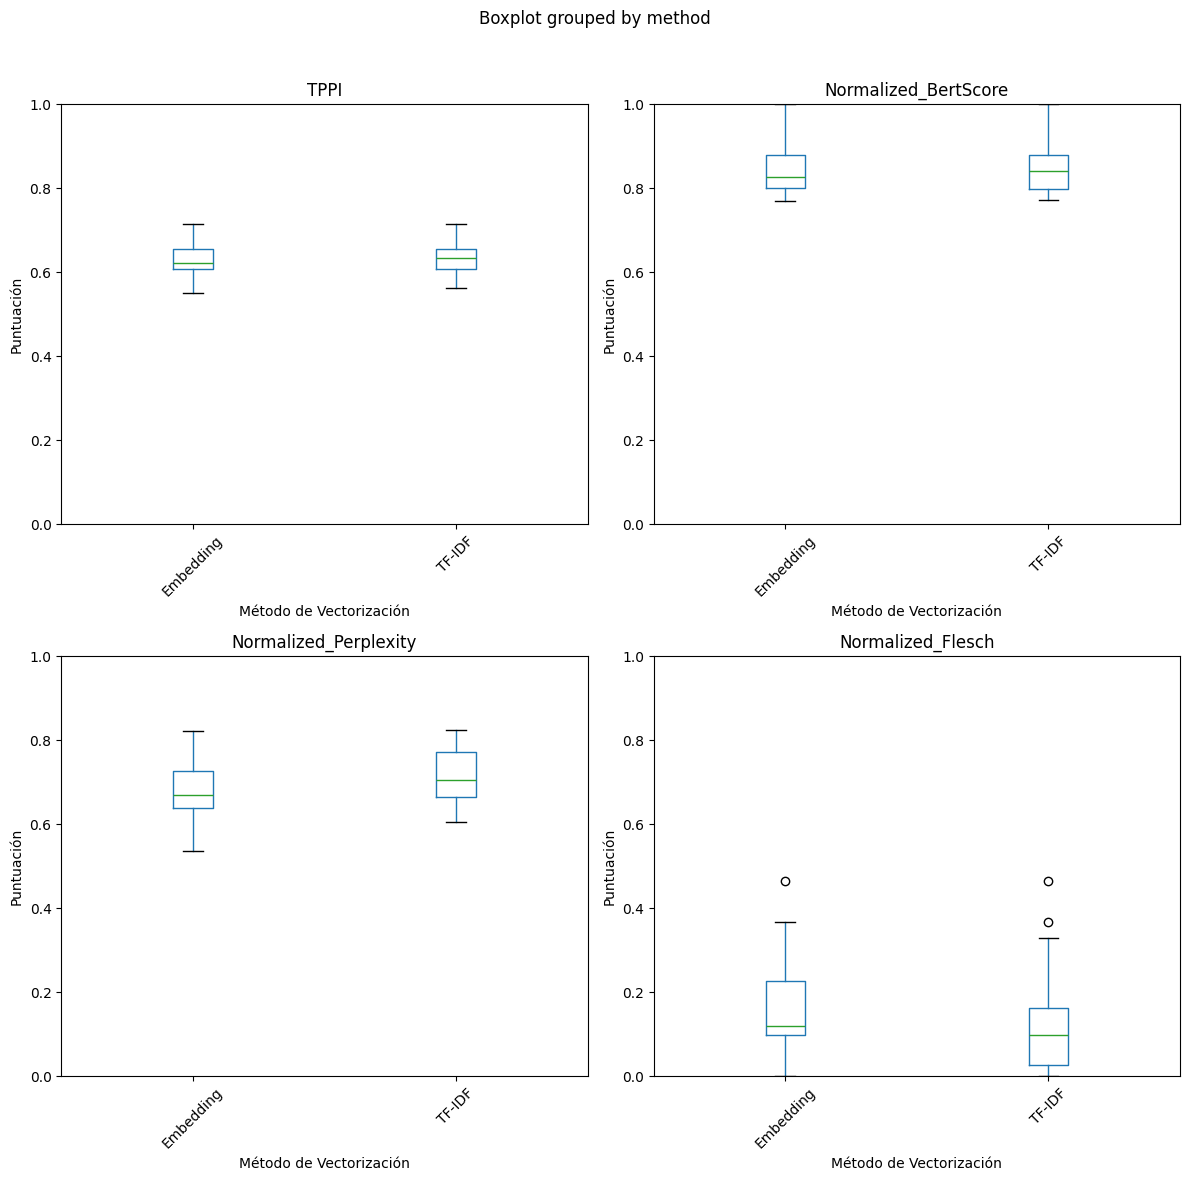

In [17]:
# Definir los nombres de las métricas para iterar
metrics = ['TPPI', 'Normalized_BertScore', 'Normalized_Perplexity', 'Normalized_Flesch']

# Crear un subplot 2x2 para los boxplots de cada métrica
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
fig.suptitle('Distribución de Métricas por Método de Vectorización', fontsize=16)

# Iterar sobre las métricas y los ejes para crear los boxplots
for ax, metric in zip(axes.flatten(), metrics):
    all_results.boxplot(column=metric, by='method', ax=ax, grid=False)
    ax.set_title(metric)
    ax.set_xlabel('Método de Vectorización')
    ax.set_ylabel('Puntuación')
    ax.set_ylim(0, 1)  # Asegurar que el gráfico esté limitado entre 0 y 1
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotar las etiquetas para mejor legibilidad

# Ajustar el layout para evitar la superposición de los títulos y etiquetas
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta los límites del rectángulo del layout
plt.show()

### 3.2 Chuking experimentation

In [18]:
def expand_by_newline(df):
    # Crear una lista de tuplas (índice original, frase)
    tuples = []
    for index, row in df.iterrows():
        for sentence in row['content'].split('\n'):
            tuples.append((index, row['file_name'], sentence.strip()))

    # Convertir la lista de tuplas en un DataFrame
    new_df = pd.DataFrame(tuples, columns=['original_index', 'file_name', 'sentence'])
    return new_df

In [19]:
sentences = expand_by_newline(df)

In [20]:
embedding_sentences_matrix = np.vstack(sentences['sentence'].apply(lambda x: get_openai_embedding(x)))
embedding_prompt_matrix = np.vstack(df['prompt'].apply(lambda x: get_openai_embedding(x)))

In [21]:
def conduct_experiment(df, sentences, vector_matrix, prompt_matrix, n=5):
    results = []
    for i in tqdm(range(len(df))):
        # Find the most relevant document
        cosine_similarities = cosine_similarity(prompt_matrix[i].reshape(1, -1), vector_matrix).flatten()
        cosine_similarities[sentences.original_index == i] = -1  # exclude the document itself
        top_n_indices = cosine_similarities.argsort()[-n:][::-1]
        combined_content = '. '.join(sentences['sentence'][j] for j in top_n_indices)

        # Calculate TPPI
        tppi_result = tppi.calculate_tppi(df['content'][i], combined_content)
        tppi_result['file_name'] = df['file_name'][i]
        tppi_result['n'] = n
        results.append(tppi_result)

    return results

In [22]:
all_results = []
for i in range(1, 11):
    all_results += conduct_experiment(df, sentences, embedding_sentences_matrix, embedding_prompt_matrix, i)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [23]:
all_results = pd.DataFrame(all_results)

In [24]:
# Calcula estadísticas básicas para cada método
statistics = all_results.groupby('n').agg({
    'TPPI': ['mean', 'std', 'min', 'max'],
    'BertScore': ['mean'],
    'Perplexity': ['mean'],
    'Flesch' : ['mean']
}).reset_index()

print(statistics)

    n      TPPI                               BertScore Perplexity     Flesch
           mean       std       min       max      mean       mean       mean
0   1  0.555949  0.077591  0.399487  0.689422  0.566067  55.546998  17.179333
1   2  0.585289  0.056359  0.489273  0.696876  0.593745  46.407069  18.326333
2   3  0.616783  0.056510  0.529341  0.717915  0.607738  36.455972  20.205667
3   4  0.617879  0.042827  0.533279  0.713742  0.620725  34.490402  18.006333
4   5  0.626755  0.039584  0.571602  0.722633  0.624898  32.606460  19.498333
5   6  0.626298  0.036087  0.567231  0.701698  0.626622  31.841366  18.319667
6   7  0.625032  0.035824  0.573268  0.704864  0.630892  32.607751  18.092667
7   8  0.627389  0.036538  0.573496  0.703997  0.630341  32.416321  19.172667
8   9  0.626653  0.036806  0.559032  0.703232  0.633160  32.382260  18.809667
9  10  0.626910  0.035156  0.555591  0.700239  0.633903  32.786914  19.240333


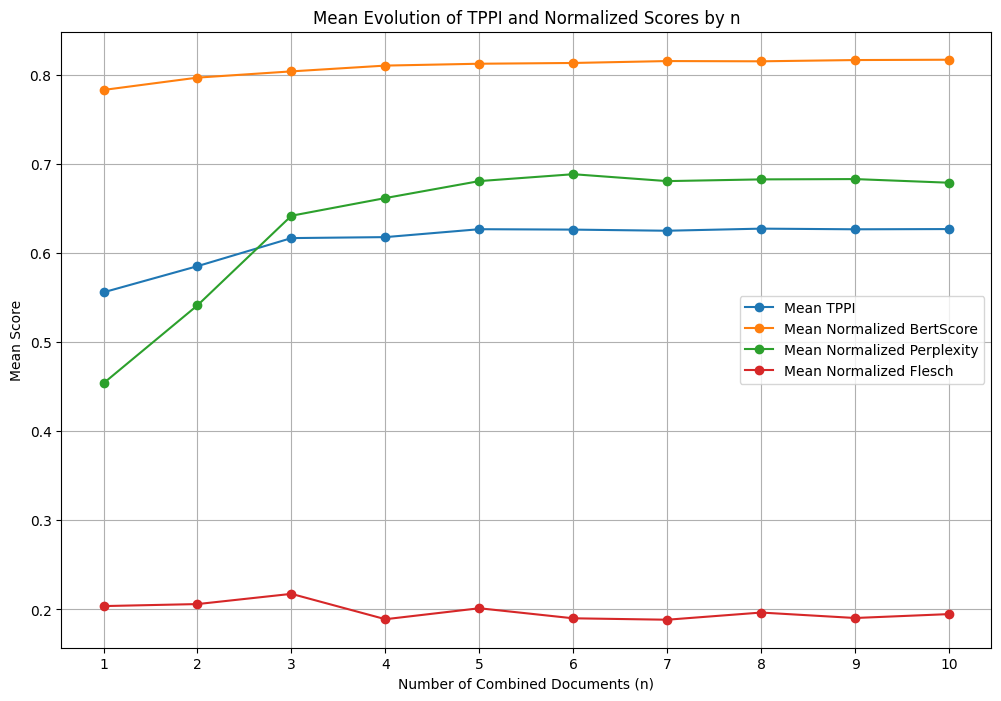

In [25]:
# Calculating mean values for each 'n'
mean_values = all_results[['TPPI', 'Normalized_BertScore', 'Normalized_Perplexity', 'Normalized_Flesch', 'n']].groupby('n').mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(mean_values['n'], mean_values['TPPI'], marker='o', label='Mean TPPI')
plt.plot(mean_values['n'], mean_values['Normalized_BertScore'], marker='o', label='Mean Normalized BertScore')
plt.plot(mean_values['n'], mean_values['Normalized_Perplexity'], marker='o', label='Mean Normalized Perplexity')
plt.plot(mean_values['n'], mean_values['Normalized_Flesch'], marker='o', label='Mean Normalized Flesch')

plt.title('Mean Evolution of TPPI and Normalized Scores by n')
plt.xlabel('Number of Combined Documents (n)')
plt.ylabel('Mean Score')
plt.xticks(mean_values['n'])  # Ensure x-axis labels match the number of documents
plt.legend()
plt.grid(True)
plt.show()